In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb
from trim_duplicates import DuplicatesData
import matplotlib.pyplot as plt

assert jax.local_device_count() >= 8

NUM_CLASSES = 4
SEED = 14
BATCH_SIZE = 128

def basemodel_process(x): return x

In [2]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("data/mendeley", rng=rng, official_split=False)
dataset_tawsifur = Dataset.load("data/tawsifur", rng=rng, official_split=False)
print("Loaded mendeley", dataset_mendeley.classnames)
print("Loaded tawsifur", dataset_tawsifur.classnames)

Loaded mendeley ['Normal', 'Viral pneumonia', 'COVID-19', 'Bacterial pneumonia']
Loaded tawsifur ['Normal', 'Viral pneumonia', 'COVID-19', 'Lung opacity']


In [15]:
def report_dups(title, count, ds):
    print(title + ":", count, "(" + str(round(count / ds.x_all.shape[0] * 1000)/10) + "%)")

def is_dup(indices, i, dont_count):
    for v in indices:
        if len(v) > 1 and i not in dont_count and i in v:
            for j in v:
                if j != i:
                    dont_count[j] = True
            return True
    return False

def count_dups(groups, ds):
    dont_count = {}
    dups_count = 0

    for i in range(ds.x_all.shape[0]):
        if is_dup(groups, i, dont_count):
            dups_count += 1
    
    return dups_count

def show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/cv_" + actual_name + "_0.pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    total_dups_two_sets = 0
    dont_count = {}

    for i in range(ds.x_all.shape[0]):       
        if is_dup(dups, i, dont_count) and is_dup(dups_pix, i, dont_count):
            total_dups_two_sets += 1

    report_dups("Total pix dups", count_dups(dups_pix.indices, ds), ds)
    report_dups("Total embed dups", count_dups(dups.indices, ds), ds)
    # report_dups("Intersection", total_dups_two_sets, ds)

    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

show_diff(dataset_mendeley, "embed")

### COUNTS DUPS INTERSECTION ACROSS CROSS VALIDATION SETS ###

actual_name = "tawsifur"
ds = dataset_tawsifur

cvs = []
for i in range(5):
    cvs.append(DuplicatesData.load("dup_data/cv_" + actual_name + "_" + str(i) + ".pickle"))
cvs.append(DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle"))

dups_in_all = 0
dont_count = {}

for i in range(ds.x_all.shape[0]):   
    in_all = True
    for cv in range(len(cvs)):
        if not is_dup(cvs[cv].indices, i, dont_count):
            in_all = False
            break
    
    if in_all:
        dups_in_all += 1

report_dups("INTERSECAO DE TODOS CV E DOS EMBEDDINGS", dups_in_all, ds)

CV-INT: 187 (0.9%)


In [14]:
print(dups_in_all)

2174


Total embed dups: 6587
Total pix dups: 6580
Complement of difference: 23
1227 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1504).jpg
8107 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (2533).jpg
4856 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (300).jpg
9018 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1571).jpg


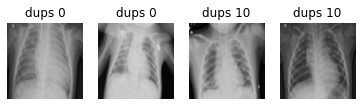

In [7]:
def custom_show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/" + actual_name + "_custom.pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    print("Total embed dups:", len(dups.indices))
    print("Total pix dups:", len(dups_pix.indices))
    print("Complement of difference:", len(diff))
    
    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

custom_show_diff(dataset_mendeley, "embed")

In [ ]:
dataset_mendeley.x_all.shape